In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple, Callable, Union, Optional
from tensor_type import Tensor
from scipy.stats import norm, expon, uniform, multivariate_normal
from torch import mm, exp, log, det, minimum, sqrt, mul
from torch.linalg import inv, det

from tqdm import tqdm

import time
import pdb

# Plotting parameters
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

def improve_mass_matrix(minv: Tensor,
                        mu: Tensor,
                        n: int,
                        qs = List[Tensor]) -> Tensor:
    '''
    This function takes a list of the burn-in parameter points q
    and the current mass matrix to estimate an improved matrix
    minv: current mass matrix
    mu: mean of distribution
    n: number of burn-in points
    qs: lsit of parameter points
    returns the mean matrix of q.q^T summed with original Minv, and M
    '''
    #pdb.set_trace()
    minv = minv.clone()
    for i in range(n):
        a = qs[i] - mu  # create rank-1 matrix
        minv.add_(a.mm(a.t()))  # sum into minv
    minv.div_(n)
    return inv(minv), minv

# Unit Test
#test_list = [torch.tensor([[2.],[3.]]), torch.tensor([[1.],[4.]])]
#ident = torch.tensor([[1.,0.],[0.,1.]])
#zero = torch.zeros((2,1))
#improve_mass_matrix(ident,zero,2, test_list)

def KE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor]=None,
       detM: Optional[float] =0.0) -> Tensor:
    '''
    This is a kinetic energy function KE(x) = -log pi(p|q), where
    pi is of general form xT.A.x
    x: is a point
    mu: is the distribution mean
    '''
    #pdb.set_trace()
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        ke = .5 * mm(x.t(), mm(Minv,x)) + const
    else:
        ke = .5 * mm(a.t(),a)
    #print(f'In KE: ke={ke}')
    return ke

def PE(x:  Tensor,
         mu: Tensor,
         Minv: Optional[Tensor] = None,
         detM: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        pe = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        pe = .5 * mm(a.t(),a)
    #print(f'In PE: ke={pe}')
    return pe

def get_autograd(func: Callable,
                 x:    Tensor,
                 mu:   Tensor,
                 Mat:  Tensor,
                 detMat: Optional[float] =0.0) -> Tuple[Tensor, Tensor]:
    '''
    dH calculates K(p) or V(q) along with associated gradient.
    x: is a tensor
    Mat: is a mass matrix
    func: is the K or V function to calculate
    returns function output and gradient
    '''
    #pdb.set_trace()
    x.requires_grad_(True) # track math operations
    x.retain_grad() # keep gradient after backward()
    out = func(x, mu, Mat, detMat)  # calculate given function
    out.backward(gradient=torch.ones(out.size()))  # Calculate grads
    x_grad = x.grad.data  # get gradients only
    x.grad = None  # reset gradient 
    x.requires_grad_(False)  # stop tracking
    return out.detach().clone(), x_grad 

# Unit Test
#t = torch.tensor([6., 4.]).view(2,1)
#tout, dt = dH(t, Minv, Tst2)

def stormer_verlet(V:    Callable,
                   q0:   Tensor,
                   p0:   Tensor,
                   mu:   Tensor,
                   Minv: Tensor,
                   eps:  float,
                   Tstep:    int) -> Tuple[Tensor, Tensor]:
    '''
    Stormer-Verlet should propagate a point in phase space
    (p,q) according to Hamiltonian H.
    
    dVdq: references a function yielding the derivative of
    potential energy V.
    q0: is initial position tensor
    p0: is initial momentum tensor
    eps: scalar time increment
    Tstep: time interval length
    returns numpy arrays q and p
    '''
    Nsteps = int(Tstep//eps)
    q, p = q0.clone(), p0.clone()    
    for n in range(Nsteps-1):
        #print(f'SV iter: {n}')
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        #print(f'In SV: first half dHdq={dHdq}')
        p -= eps * dHdq/2 # half momentum step
        q += eps * p # full parameter step
        
    _, dHdq = get_autograd(V, q, mu, Minv, detM)
    #print(f'In SV: second half dHdq={dHdq}')
    p -= eps * dHdq # full momentum step

    return q,-p 

# Monitor function 
G = lambda p,q: -1.5*q.t().mm(p)/q.t().mm(q)

def adap_stormer_verlet(T:   Callable, # kinetic energy
                        V:   Callable, # potential energy
                        G:   Callable, # monitor function
                       q0:   Tensor,   # position
                       p0:   Tensor,   # momentum
                       mu:   Tensor,   
                       Minv: Tensor,
                       eps:  float,
                       Tstep:    int) -> Tuple[Tensor, Tensor]:
    #pdb.set_trace()
    Nsteps = int(Tstep//eps) # number of steps to run
    q, p = q0.clone(), p0.clone()  # copy incoming tensors
    rho = 1. - eps*G(p,q)/2.  # set intial adaptive time
    pq_traj = [] #np.zeros((2,Nsteps))
    time_traj = [] #np.zeros(Nsteps)
    step_sum = 0.
    cosine = .0
    while(cosine<.9):
        rho  += eps * G(p,q)  # update adaptive time
        
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        p -= eps * dHdq/(2. * rho)
        
        _, dHdp = get_autograd(T, p, mu, Minv, detM)
        q += eps * dHdp/rho
        print(f'Step: {eps/rho}')
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        p -= eps * dHdq/(2.*rho)
        
        qnp = q.data.numpy()
        #print(f'shape {qnp.shape}')
        pq_traj.append(qnp)
        time_traj.append(rho)
        print(f'Step sum: {step_sum}')
        step_sum += rho
        cosine = torch.abs(q0.t().mm(q)/(torch.norm(q0)*torch.norm(q)))
        print(f'Cosine: {cosine}')
        
    return q, -p, np.squeeze(pq_traj), time_traj
    
def acceptance(q0: Tensor,
               p0: Tensor,
               q:  Tensor,
               p:  Tensor,
               mu: Tensor,
               Minv: Optional[Tensor]=None) -> Tuple[Tensor, bool]:
    '''
    This function calculates the acceptance ratio for a proposal point.
    as min(1, exp(deltaE)) and checks this against a random uniform observer
    value. 
    q,q0,p,p0: Tensors
    mu: Tensor
    Minv: Tensor
    Returns a point and a boolean flag denoting accept or not accept
    '''
    #pdb.set_trace()
    KE0, PE0       = KE(q0, mu, Minv, detM) , PE(p0, mu, Minv, detM) 
    KEstar, PEstar = KE(q, mu, Minv, detM)  , PE(p, mu, Minv, detM)
    
    #print(f'ke0={torch.round(KE0)}   pe0={torch.round(PE0)}   ke*={torch.round(KEstar)}   pe*={torch.round(PEstar)}')
    ke_diff = exp((KE0 + PE0) - (KEstar + PEstar)).item()
    #print(f'E0-E = {ke_diff:2f}')
    r = min(1., ke_diff)
    obs = uniform.rvs()
    #print(f'observer{obs:.2f} < {r:.2f} ratio')
    if obs < r:
        point = q
        acceptFlag = True
        #print(f'Energy: {KEstar + PEstar}')
    else:
        point = q0
        acceptFlag = False
    return point, acceptFlag


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]

Step: tensor([[0.0101]])
Step sum: 0.0
Cosine: tensor([[1.0000]])
Acceptance rate: 1.00




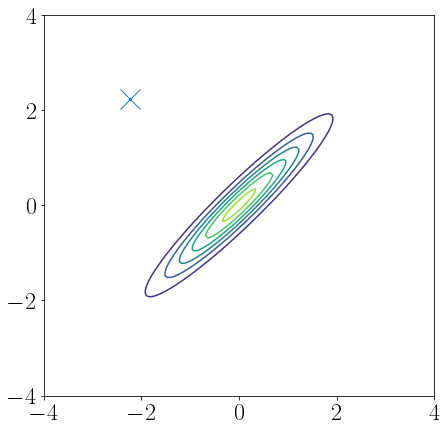

In [33]:
T = 1.  # Full time-steps
eps = .01  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 1  # Number of q's to test 
D = 2  # Dimension of q
Mlst = [[1., .95],
        [.95, 1.]]
M = torch.tensor(Mlst)
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.],[0.]],dtype=torch.float32)
mu.size()

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic
allPaths = qPath = torch.zeros((Nq, Nsteps, D))
pathFlag = []

# 
# np.random.uniform(low=-4., high=4., size=(D,1)) #(2,1)
#print(f'Q0 is : {Q0}')

# Loop iterations
for n in tqdm(range(Nq)):
    #print(f'Outer loop: {n}')
    qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    Q0 = np.array([[-2.],[2.]])
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    p0 = torch.from_numpy(norm.rvs(size=(D,1))).type(torch.float32).view(2,1)
    #print(p0.size())
    # q0,p0 are (2,1) tensors
    #print(f'q0 = {q0}\np0 = {p0}')
    q, p, pq_t, time_t = adap_stormer_verlet(KE, PE, G, q0,
                                             p0, mu, Minv, eps, T)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
        #print('ACCEPTED'+'-'*30)
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    Q0 = q0.numpy() # Start next SV pass from good...
    # ...(within distribution) q0=Q0 and perturb momentum p0.

print(f'Acceptance rate: {accepted/Nq:.2f}\n\n')    

acceptedPoints_np = acceptedPoints.numpy()
allPaths_np = allPaths.numpy()
allPaths_np.shape

N    = 200
X    = np.linspace(-6, 6, N)
Y    = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
rv   = multivariate_normal([0, 0], Mlst)
Z    = rv.pdf(pos)

plt.figure(figsize=(7,7))
plt.contour(X, Y, Z)
plt.plot(pq_t[0], pq_t[1], 'x-', ms=20., label='pq-trajectory')
plt.scatter(acceptedPoints_np[0,:], acceptedPoints_np[1,:], s=5.)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()

/home/bwhiteak/anaconda3/envs/sigenv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


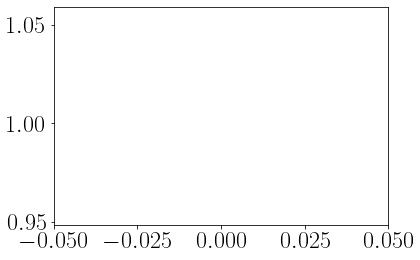

In [31]:
plt.plot(time_t)
plt.show()

## Pathological Behavior

Betancourt2018 states that for standard MCMC the Markov <br>
transitions have difficulty exploring a traget distribution <br>
Where the typical set pinches into a region of high curvature.<br>
<br>
Markov transitions cannot resolve these details and enter such regions.<br>
These areas are missed/ignored during exploration.<br>
To compensate the MCMC becomes stuck near the pinch leading to <br>
overcorrection. This induces a bias in the other direction and the chain escapes the area to continue exploration. The estimator<br>
will oscillate around the true expected value.

In the "Handbook of MCMC" (Gelman) this is sticking is referred to as pseudo-convergence.

**Gelman's split $\hat{R}$ statistic is a powerful diagnostic.<br>**

**May be a good sanity check for higher dimension to compare how<br>
acceptance rate drops between random walk, HMC, adaptive step HMC as dimension<br>
increases.** 